# **Classifying Gaussians using CNN**
* **Basic concepts learnt from: A Deep understanding of Deep Learning (with Python intro) - Mark X Cohen (Udemy) - https://www.udemy.com/course/deeplearning_x**
* **Extended learning and understanding by VigyannVeshi**


In [1]:
# basic deep learning libraries
import numpy as np
import torch as tr
import torch.nn as nn
import torch.nn.functional as F

# import summary libraries for model information
from torchsummary import summary

# import dataset/loader libraries
from torch.utils.data import TensorDataset,DataLoader
from sklearn.model_selection import train_test_split

# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [2]:
# Creating Gaussian Blurs with different widths
nPerClass=1000
imgSize=91

x=np.linspace(-4,4,imgSize)
X,Y=np.meshgrid(x,x)

# the two widths (arbitary units {a.u.})
widths=[1.8,2.4]

# initialize tensors containing images and labels
images=tr.zeros(2*nPerClass,1,imgSize,imgSize)
labels=tr.zeros(2*nPerClass)

print(labels.shape)

for i in range(2*nPerClass):

    # create the gaussian with random centers
    ro=2*np.random.randn(2) # ro-> random offset
    G=np.exp(-((X-ro[0])**2+(Y-ro[1])**2)/(2*widths[i%2]**2))

    # and add noise
    G=G+np.random.randn(imgSize,imgSize)/5

    # add to tensor
    images[i,:,:,:]=tr.Tensor(G).view(1,imgSize,imgSize)
    labels[i]= i%2

labels = labels[:,None] # makes labels shape from torch.Size([2000]) to torch.Size([2000,1])
print(labels.shape)

torch.Size([2000])
torch.Size([2000, 1])


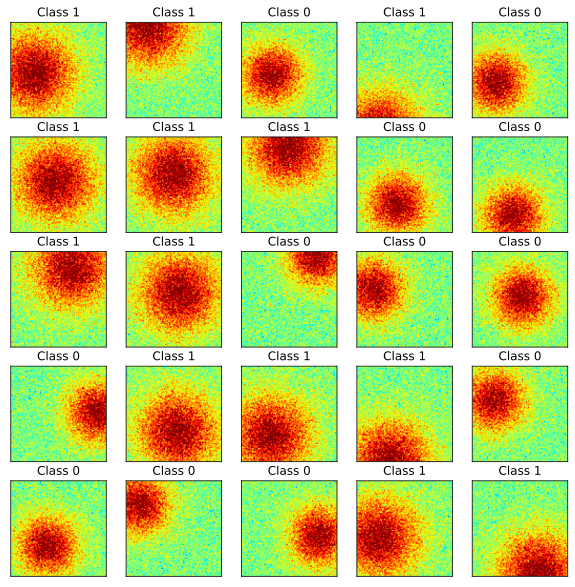

In [3]:
# visualize some images
fig,axs=plt.subplots(5,5,figsize=(10,10))

for i,ax in enumerate(axs.flatten()):
    whichpic=np.random.randint(2*nPerClass)
    G=np.squeeze(images[whichpic,:,:])
    ax.imshow(G,vmin=-1,vmax=1,cmap="jet")
    ax.set_title('Class %s'%int(labels[whichpic].item()))
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [4]:
# Create train/test groups using Dataloader

# step 2: use scikit-learn to split the data
train_data,test_data,train_labels,test_labels=train_test_split(images,labels,test_size=0.1)

# step 3: convert to Pytorch Datasets
train_data=TensorDataset(train_data,train_labels)
test_data= TensorDataset(test_data,test_labels)

# step 4: translate into dataloader objects
batchsize=32
train_loader=DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [5]:
# check size (should be images x channels x width x height)
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)

torch.Size([1800, 1, 91, 91])
torch.Size([1800, 1])


In [6]:
# Create the DL model

def createNet(lr=0.001):
    class GaussNet(nn.Module):
        def __init__(self):
            super().__init__()

            # all layers in one go using nn.Sequential
            self.enc=nn.Sequential(
                nn.Conv2d(1,6,kernel_size=3,padding=1),  # output size: (91+2*1-3)/1+1=91
                nn.ReLU(),                   # Note: ReLU is treated like a "layer"
                nn.AvgPool2d(2,2),           # Output Size: 91//2 = 45
                nn.Conv2d(6,4,kernel_size=3,padding=1),  # output size: (45+2*1-3)/1+1=45
                nn.ReLU(),                   # Note: ReLU is treated like a "layer"
                nn.AvgPool2d(2,2),           # Output Size: 45//2 = 22
                nn.Flatten(),                # Vectorize convolution output
                nn.Linear(22*22*4,50),       # Output Size: 50
                nn.Linear(50,1),             # Output Size: 1
            )

        def forward(self,x):
            return self.enc(x)
        
    # create the model instance
    net=GaussNet()

    # loss function
    lossfun=nn.BCEWithLogitsLoss()

    # optimizer
    optimizer = tr.optim.Adam(net.parameters(),lr=lr)

    return net,lossfun,optimizer

In [7]:
# test the model with one batch
net,lossfun,optimizer=createNet()

X,y = next(iter(train_loader))
yHat=net(X)

# check size of output
print(' ')
print(yHat.shape)

# now let's compute the loss
loss=lossfun(yHat,y)
print(' ')
print('Loss: ')
print(loss)

 
torch.Size([32, 1])
 
Loss: 
tensor(0.6964, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [8]:
# count the total number of parameters in the model
summary(net,(1,imgSize,imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
              ReLU-2            [-1, 6, 91, 91]               0
         AvgPool2d-3            [-1, 6, 45, 45]               0
            Conv2d-4            [-1, 4, 45, 45]             220
              ReLU-5            [-1, 4, 45, 45]               0
         AvgPool2d-6            [-1, 4, 22, 22]               0
           Flatten-7                 [-1, 1936]               0
            Linear-8                   [-1, 50]          96,850
            Linear-9                    [-1, 1]              51
Total params: 97,181
Trainable params: 97,181
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.00
Params size (MB): 0.37
Estimated Total Size (MB): 1.41
---------------------------------------------

In [9]:
# Create a function that trains the model

def trainModel(train_loader,test_loader,n_epochs=10):
    # create a new model
    net,lossfun,optimizer=createNet()

    # initialize losses
    trainLoss = tr.zeros(n_epochs)
    testLoss = tr.zeros(n_epochs)
    trainAcc = tr.zeros(n_epochs)
    testAcc = tr.zeros(n_epochs)

    # loop over epochs
    for epochi in range(n_epochs):

        # loop over training data batches
        batchLoss=[]
        batchAcc=[]

        for X,y in train_loader:

            # forward pass and loss
            yHat=net(X)
            loss=lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())
            batchAcc.append(tr.mean(((yHat>0.5)==y).float()).item())

            # end of batch loop ...

        # and get the average losses across the batches
        trainLoss[epochi]=np.mean(batchLoss)
        trainAcc[epochi]=100*np.mean(batchAcc)

        # test accuracy
        X,y=next(iter(test_loader))
        with tr.no_grad(): # deactivates autograd
            yHat=net(X)
            loss=lossfun(yHat,y)

        # compare the following really long lines of code to the training accuracy lines
        testLoss[epochi]=loss.item()
        testAcc[epochi]=100*tr.mean(((yHat>0)==y).float()).item() # doubt here

    # end of epochs

    # function output
    return trainLoss,testLoss,trainAcc,testAcc,net

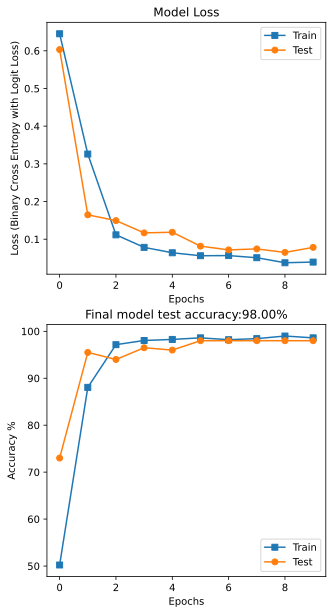

In [10]:
# Run the model and show the results
trainLoss,testLoss,trainAcc,testAcc,net=trainModel(train_loader,test_loader)

fig,ax=plt.subplots(2,1,figsize=(5,10))

ax[0].plot(trainLoss,'s-',label="Train")
ax[0].plot(testLoss,'o-',label="Test")
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (Binary Cross Entropy with Logit Loss)')
ax[0].set_title('Model Loss')
ax[0].legend()

ax[1].plot(trainAcc,'s-',label="Train")
ax[1].plot(testAcc,'o-',label="Test")
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy %')
ax[1].set_title(f'Final model test accuracy:{testAcc[-1]:.2f}%')
ax[1].legend()
plt.show()

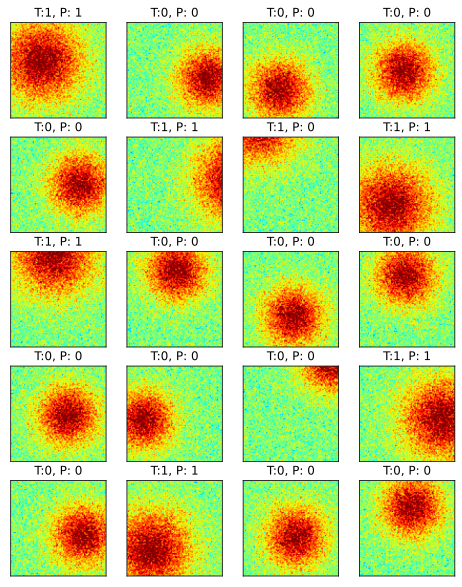

In [11]:
# visualize the output
X,y=next(iter(test_loader)) # extract X,y from the test loader
yHat=net(X)

fig,axs=plt.subplots(5,4,figsize=(8,10))

for i,ax in enumerate(axs.flatten()):
    G=tr.squeeze(X[i,0,:,:]).detach()
    ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
    t=(int(y[i].item())),int(yHat[i].item()>0.5)
    ax.set_title(f'T:{t[0]}, P: {t[1]}')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [12]:
# look at the filters
print(net)

layer1W=net.enc[0].weight
layer3W=net.enc[3].weight

print('')
print(layer1W.shape)
print(layer3W.shape)

GaussNet(
  (enc): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1936, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)

torch.Size([6, 1, 3, 3])
torch.Size([4, 6, 3, 3])


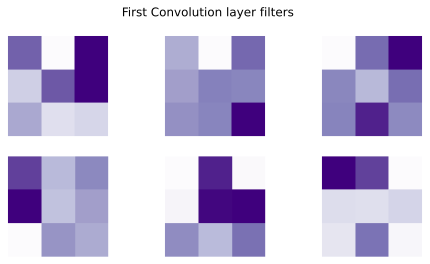

In [13]:
fig,axs=plt.subplots(2,3,figsize=(8,4))

for i,ax in enumerate(axs.flatten()):
    ax.imshow(tr.squeeze(layer1W[i,:,:,:]).detach(),cmap="Purples")
    ax.axis('off')

plt.suptitle('First Convolution layer filters')
plt.show()

In [14]:
print(np.unravel_index(0,(4,6)))
print(np.unravel_index(7,(4,6)))

(0, 0)
(1, 1)


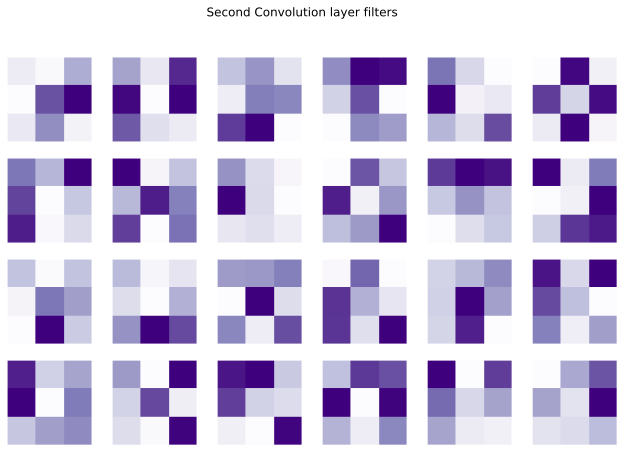

In [15]:
fig,axs=plt.subplots(4,6,figsize=(11,7))

for i in range(6*4):
    idx=np.unravel_index(i,(4,6))
    axs[idx].imshow(tr.squeeze(layer3W[idx[0],idx[1],:,:]).detach(),cmap="Purples")
    axs[idx].axis('off')

plt.suptitle('Second Convolution layer filters')
plt.show()

**Additional Explorations**

In [16]:
# 1) Rewrite the model architecture without using nn.Sequential. Your final result must be the same as the current version, just defined in a different way. This is great practice at constructing models using classes. 

# 2) Find and plot the stimuli that the model guessed incorrectly. Is the correct answer obvious to you? Do the errors tend to be obscured by the boundaries of the image, or is there any other reason you can find for why the model got those wrong?
# --> errors tend to be obscured by the boundaries of the image

# 3) Notice the choice of architecture here: 6 channels in the first convolution layer and 4 channels in the second. In the lecture I said that CNNs typically get wider with each successive "convpool block." Does that mean that this model is wrong? Or suboptimal? Think of some arguments for and against this organization. Then modify the code to swap the widths (4 channels in the first conv layer and 6 channels in the second conv layer). Does that affect the model's performance?

# --> technically using more filter/channels down the line increases the length of the output vector given to the ANN to classify
# --> observations show not much of a difference in the performancefig,axs=plt.subplots(4,6,figsize=(11,7))

for i in range(6*4):
    idx=np.unravel_index(i,(4,6))
    axs[idx].imshow(tr.squeeze(layer3W[idx[0],idx[1],:,:]).detach(),cmap="Purples")
    axs[idx].axis('off')

plt.suptitle('Second Convolution layer filters')
plt.show() 

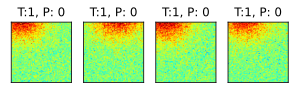

In [17]:
# plotting the stimuli that the model guessed incorrectly
X,y=next(iter(test_loader)) # extract X,y from the test loader
yHat=net(X)

rows=int(sum(((yHat>0)!=y).float()))
inc_pred_idx=np.where(((yHat>0)!=y))[0]
fig,axs=plt.subplots(1,rows,figsize=(5,3))

for i,ax in enumerate(axs.flatten()):
    G=tr.squeeze(X[inc_pred_idx[i],0,:,:]).detach()
    ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
    t=(int(y[inc_pred_idx[i]].item())),int(yHat[inc_pred_idx[i]].item()>0.5)
    ax.set_title(f'T:{t[0]}, P: {t[1]}')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [18]:
# Create the DL model to test (3)

def createNet(lr=0.001):
    class GaussNet(nn.Module):
        def __init__(self):
            super().__init__()

            # all layers in one go using nn.Sequential
            self.enc=nn.Sequential(
                nn.Conv2d(1,4,kernel_size=3,padding=1),  # output size: (91+2*1-3)/1+1=91
                nn.ReLU(),                   # Note: ReLU is treated like a "layer"
                nn.AvgPool2d(2,2),           # Output Size: 91//2 = 45
                nn.Conv2d(4,6,kernel_size=3,padding=1),  # output size: (45+2*1-3)/1+1=45
                nn.ReLU(),                   # Note: ReLU is treated like a "layer"
                nn.AvgPool2d(2,2),           # Output Size: 45//2 = 22
                nn.Flatten(),                # Vectorize convolution output
                nn.Linear(22*22*6,50),       # Output Size: 50
                nn.Linear(50,1),             # Output Size: 1
            )

        def forward(self,x):
            return self.enc(x)
        
    # create the model instance
    net=GaussNet()

    # loss function
    lossfun=nn.BCEWithLogitsLoss()

    # optimizer
    optimizer = tr.optim.Adam(net.parameters(),lr=lr)

    return net,lossfun,optimizer

In [19]:
# test the model with one batch
net,lossfun,optimizer=createNet()

X,y = next(iter(train_loader))
yHat=net(X)

# check size of output
print(' ')
print(yHat.shape)

# now let's compute the loss
loss=lossfun(yHat,y)
print(' ')
print('Loss: ')
print(loss)

 
torch.Size([32, 1])
 
Loss: 
tensor(0.6910, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


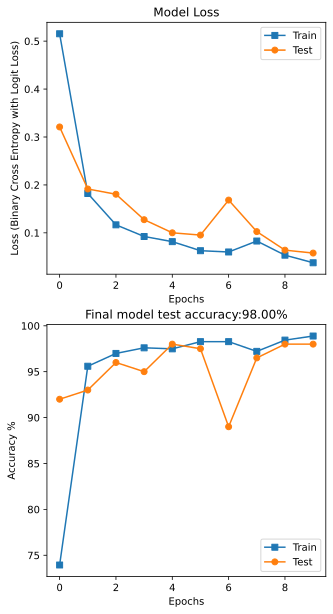

In [20]:
# Run the model and show the results
trainLoss,testLoss,trainAcc,testAcc,net=trainModel(train_loader,test_loader)

fig,ax=plt.subplots(2,1,figsize=(5,10))

ax[0].plot(trainLoss,'s-',label="Train")
ax[0].plot(testLoss,'o-',label="Test")
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (Binary Cross Entropy with Logit Loss)')
ax[0].set_title('Model Loss')
ax[0].legend()

ax[1].plot(trainAcc,'s-',label="Train")
ax[1].plot(testAcc,'o-',label="Test")
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy %')
ax[1].set_title(f'Final model test accuracy:{testAcc[-1]:.2f}%')
ax[1].legend()
plt.show()

In [21]:
# look at the filters
print(net)

layer1W=net.enc[0].weight
layer3W=net.enc[3].weight

print('')
print(layer1W.shape)
print(layer3W.shape)

GaussNet(
  (enc): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(4, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2904, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)

torch.Size([4, 1, 3, 3])
torch.Size([6, 4, 3, 3])


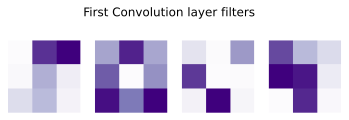

In [22]:
fig,axs=plt.subplots(1,4,figsize=(6,2))

for i,ax in enumerate(axs.flatten()):
    ax.imshow(tr.squeeze(layer1W[i,:,:,:]).detach(),cmap="Purples")
    ax.axis('off')

plt.suptitle('First Convolution layer filters')
plt.show()

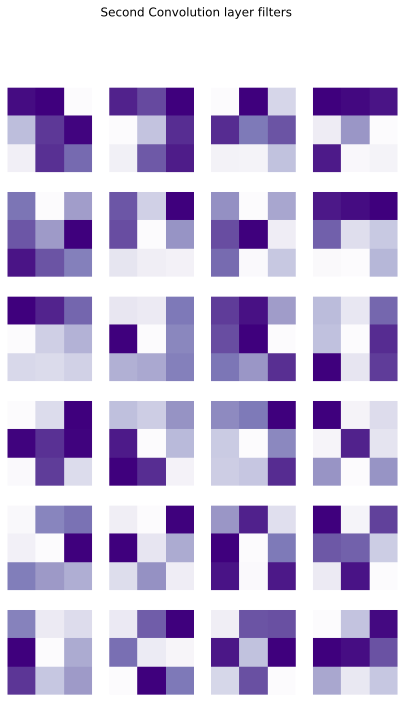

In [23]:
fig,axs=plt.subplots(6,4,figsize=(7,11))

for i in range(6*4):
    idx=np.unravel_index(i,(6,4))
    axs[idx].imshow(tr.squeeze(layer3W[idx[0],idx[1],:,:]).detach(),cmap="Purples")
    axs[idx].axis('off')

plt.suptitle('Second Convolution layer filters')
plt.show()